# Customer Churn Prediction in Telco

In [69]:
import pyspark
from pyspark import SparkConf, SparkContext
#conf = (SparkConf()
#         .setMaster("local")
#         .setAppName("My app")
#        .set("spark.executor.memory", "2g"))
#sc = SparkContext(conf = conf)

from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)
schema = StructType([ \
    StructField("state", StringType(), True), \
    StructField("account_length", DoubleType(), True), \
    StructField("area_code", StringType(), True), \
    StructField("phone_number", StringType(), True), \
    StructField("intl_plan", StringType(), True), \
    StructField("voice_mail_plan", StringType(), True), \
    StructField("number_vmail_messages", DoubleType(), True), \
    StructField("total_day_minutes", DoubleType(), True), \
    StructField("total_day_calls", DoubleType(), True), \
    StructField("total_day_charge", DoubleType(), True), \
    StructField("total_eve_minutes", DoubleType(), True), \
    StructField("total_eve_calls", DoubleType(), True), \
    StructField("total_eve_charge", DoubleType(), True), \
    StructField("total_night_minutes", DoubleType(), True), \
    StructField("total_night_calls", DoubleType(), True), \
    StructField("total_night_charge", DoubleType(), True), \
    StructField("total_intl_minutes", DoubleType(), True), \
    StructField("total_intl_calls", DoubleType(), True), \
    StructField("total_intl_charge", DoubleType(), True), \
    StructField("number_customer_service_calls", DoubleType(), True), \
    StructField("churned", StringType(), True)])

churn_data = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .load('churn.all.csv', schema = schema)

# Basic DataFrame Operations

In [70]:
count = churn_data.count()
voice_mail_plans = churn_data.filter(churn_data.voice_mail_plan == " yes").count()

"%d, %d" % (count, voice_mail_plans)

'5000, 1323'

# Feature Visualization

In [71]:
import pandas
sample_data = churn_data.sample(False, 0.5, 83).toPandas()
sample_data.head()


,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128.0,415,382-4657,no,yes,25.0,265.1,110.0,45.07,...,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1.0,False.
1,OH,107.0,415,371-7191,no,yes,26.0,161.6,123.0,27.47,...,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,False.
2,NJ,137.0,415,358-1921,no,no,0.0,243.4,114.0,41.38,...,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,False.
3,OK,75.0,415,330-6626,yes,no,0.0,166.7,113.0,28.34,...,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,False.
4,AL,118.0,510,391-8027,yes,no,0.0,223.4,98.0,37.98,...,101.0,18.75,203.9,118.0,9.18,6.3,6.0,1.70,0.0,False.


In [72]:
numeric_cols = ["account_length", "number_vmail_messages", "total_day_minutes",
                "total_day_calls", "total_day_charge", "total_eve_minutes",
                "total_eve_calls", "total_eve_charge", "total_night_minutes",
                "total_night_calls", "total_intl_minutes", "total_intl_calls",
                "total_intl_charge"]

categorical_cols = ["state", "international_plan", "voice_mail_plan", "area_code"]

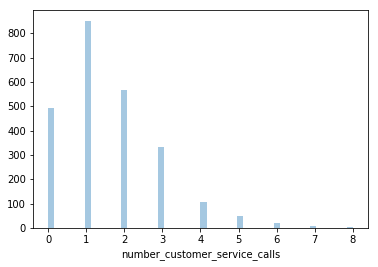

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

sb.distplot(sample_data['number_customer_service_calls'], kde=False)

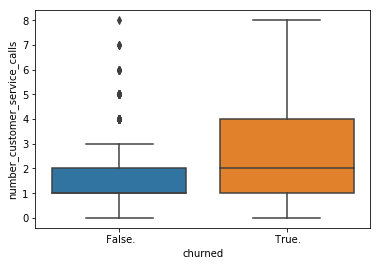

In [74]:
sb.boxplot(x="churned", y="number_customer_service_calls", data=sample_data)

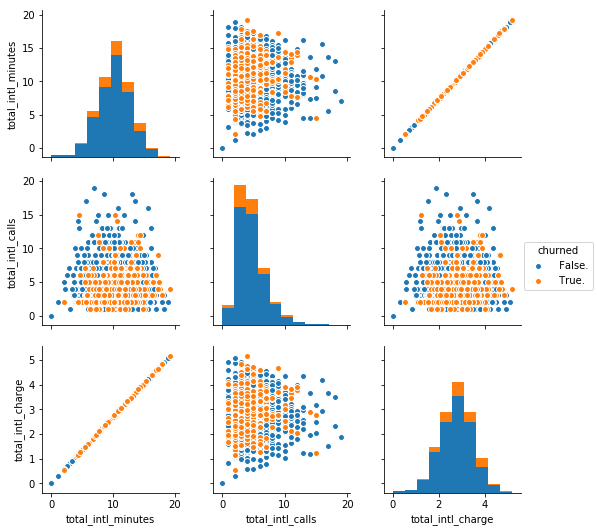

In [75]:
example_numeric_data = sample_data[["total_intl_minutes", "total_intl_calls",
                                       "total_intl_charge", "churned"]]
sb.pairplot(example_numeric_data, hue="churned")

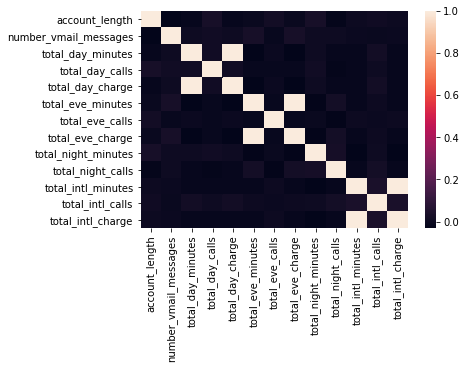

In [76]:
corr = sample_data[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]].corr()

sb.heatmap(corr)

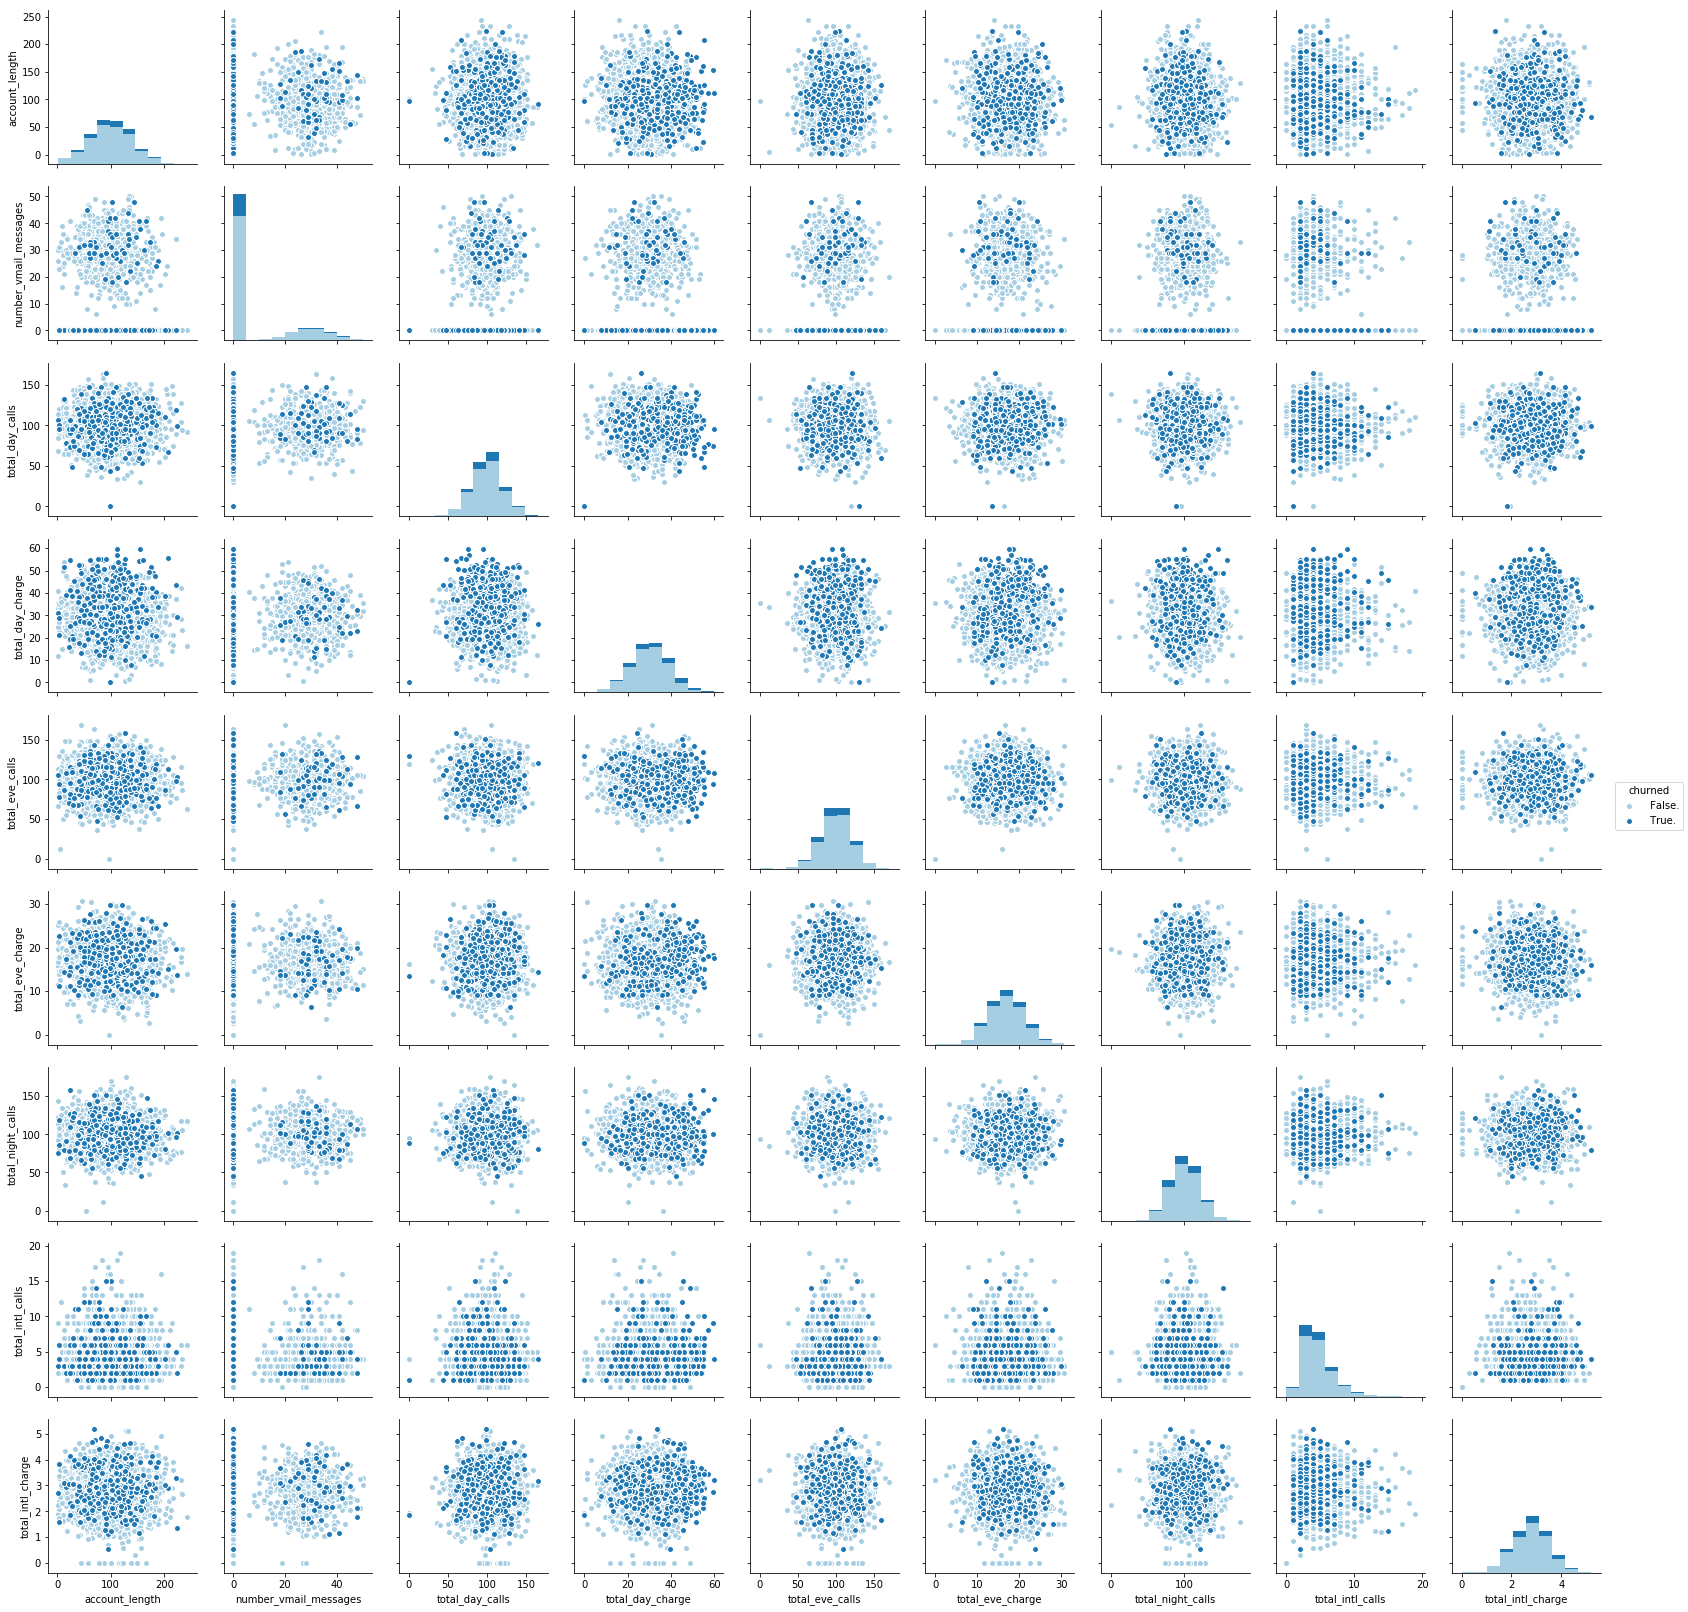

In [77]:
reduced_numeric_cols = ["account_length", "number_vmail_messages", "total_day_calls",
                        "total_day_charge", "total_eve_calls", "total_eve_charge",
                        "total_night_calls", "total_intl_calls", "total_intl_charge"]

sb.pairplot(sample_data[reduced_numeric_cols + ['churned']], hue="churned", palette='Paired')

# Build Classification Model using MLLib

Feature Extraction and Model Training

We need to:
- Code features that are not already numeric
- Gather all features we need into a single column in the DataFrame.
- Split labeled data into training and testing set
- Fit the model to the training data.

Feature Extraction
We need to define our input features.

In [78]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

label_indexer = StringIndexer(inputCol = 'churned', outputCol = 'label')
plan_indexer = StringIndexer(inputCol = 'intl_plan', outputCol = 'intl_plan_indexed')

assembler = VectorAssembler(
    inputCols = ['intl_plan_indexed'] + reduced_numeric_cols,
    outputCol = 'features')

# Using Decision Tree for Classification

In [79]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

classifier = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'features')

pipeline = Pipeline(stages=[plan_indexer, label_indexer, assembler, classifier])

(train, test) = churn_data.randomSplit([0.8, 0.2],seed=20)
model = pipeline.fit(train)

In [80]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator()
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})

print "The AUROC is %s and the AUPR is %s." % (auroc, aupr)

train_accuracy = evaluator.evaluate(model.transform(train))
test_accuracy = evaluator.evaluate(model.transform(test))

print "The accuracy for training is %s percent and the accuracy for testing is %s percent." \
    %(round(train_accuracy*100,2),round(test_accuracy*100,2))

The AUROC is 0.468536555618 and the AUPR is 0.242155998198.
The accuracy for training is 48.21 percent and the accuracy for testing is 46.85 percent.


# Using Random Forest for Classification

As we can see that the result of classification using decisionTree is very low, so we're trying to predict using random forest algorithm

In [81]:
from pyspark.ml.classification import RandomForestClassifier

classifier = RandomForestClassifier(numTrees=10, maxDepth=5, labelCol="label", seed=42)
pipeline = Pipeline(stages=[plan_indexer, label_indexer, assembler, classifier])

(train,test) = churn_data.randomSplit([0.8,0.2],seed=20)
model = pipeline.fit(train)

In [82]:
predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator()
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
"The AUROC is %s and the AUPR is %s." % (auroc, aupr)

'The AUROC is 0.788132492333 and the AUPR is 0.64210859331.'

In [83]:
train_accuracy = evaluator.evaluate(model.transform(train))
test_accuracy = evaluator.evaluate(model.transform(test))

"The accuracy for training is %s percent and the accuracy for testing is %s percent." \
    %(round(train_accuracy*100,2),round(test_accuracy*100,2))

'The accuracy for training is 84.41 percent and the accuracy for testing is 78.81 percent.'